## CDM predicts an abundance of substructure, which has the unfortunate consequence of making lensing computations extremely slow if all halos are included in computations. Depending on the problem at hand, however, you may not need to include every single halo in your computations. 

### In pyHalo, you can manipulate realizations to keep only halos more massive than X inside at aperture size R around the path traversed by a lensed light ray, a functionality this notebook demonstrates. 

### First, we'll start by creating a new realization of halos... 

In [1]:
from pyHalo.pyhalo import pyHalo
import numpy as np
from time import time
import matplotlib.pyplot as plt

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

In [2]:
zlens, zsource = 0.6, 2.5
cone_opening_angle = 8.
rendering_volume = 'DOUBLE_CONE' 
kwargs_halo_mass_function = {'geometry_type': rendering_volume}
mass_definition = 'TNFW' 
log_mlow = 6. 
log_mhigh = 10 
power_law_index = -1.9 
delta_power_law_index = -0.5
LOS_norm = 2. 
sigma_sub = 0.0 
r_tidal = '0.25Rs' 
log_m_host = 13.3

log_mass_sheet_min = 6
log_mass_sheet_max = 10

pyhalo = pyHalo(zlens, zsource, kwargs_halo_mass_function=kwargs_halo_mass_function)

realization_kwargs = {'mass_func_type': 'POWER_LAW', 'log_mlow': log_mlow, 'log_mhigh': log_mhigh, 
                      'log_mass_sheet_min': log_mlow, 'log_mass_sheet_max': log_mhigh, 
                      'mdef_main': mass_definition,'mdef_los': mass_definition, 'sigma_sub': sigma_sub,
                      'cone_opening_angle': cone_opening_angle, 'delta_power_law_index': delta_power_law_index,
                      'log_m_host': log_m_host, 'power_law_index': power_law_index, 'r_tidal': r_tidal,
                      'LOS_normalization': LOS_norm}

realization_type = 'composite_powerlaw'
astropy_instance = pyhalo.astropy_cosmo
realization_init = pyhalo.render(realization_type, realization_kwargs, nrealizations=1)[0]
print('realization contains '+str(len(realization_init.halos))+' halos')

realization contains 130992 halos


### Now create a lens model, solve the lens equation to get some mock image positions

In [6]:
kwargs_macromodel = [{'theta_E': 1.25, 'center_x': 0., 'center_y': 0., 'e1': 0., 'e2': 0.3, 'gamma': 2.},
                    {'gamma1': 0.04, 'gamma2': 0.0},
                    ]

lens_model_list_macro = ['EPL', 'SHEAR']
redshift_list_macro = [zlens, zlens]

lens_model_macro = LensModel(lens_model_list_macro, zlens, zsource, redshift_list_macro, 
                             cosmo=astropy_instance, multi_plane=True)

solver = LensEquationSolver(lens_model_macro)
source_x, source_y = 0.08, 0.04
x_image, y_image = solver.findBrightImage(source_x, source_y, kwargs_macromodel)

### Now use the functionality in pyhalo to interpolate the paths traversed by the light in this lens system

In [7]:
interpolated_ray_paths_x, interpolated_ray_paths_y = pyhalo.interpolate_ray_paths(x_image, y_image, lens_model_macro, kwargs_macromodel, zsource,
                              terminate_at_source=True, source_x=source_x, source_y=source_y)

# This returns 8 (4 x 2) instances of scipy.interpolate.interp1d that return the angular coordinate of a ray in 
# arcsec given a comoving distance

### The tool we need is a method called "filter" in the realization class. It will remove all halos based on several cuts on mass and distance from each interpolated ray path. We can then combine it with another realization using the "join" method

In [8]:
# the lensing volume is split at the main deflector redshift, so front means <= zlens and back means >
# the aperture radii and mass_allowed in aperture radius tell the code what minimum halo mass we're allowed to keep in 
# apertures around each light ray with size "aperture_radius_front/back"

aperture_radius_front = 0.15
aperture_radius_back = 0.15
log_mass_allowed_in_aperture_front = 6.
log_mass_allowed_in_aperture_back = 6.
log_mass_allowed_global_front = 8.
log_mass_allowed_global_back = 8.
# Here, we'll keep halos more massive than 10^8 everywhere, but we'll only keep halos with mass between 10^6-10^8 
# inside apertures with size 0.3 arcsec

realization_filtered = realization_init.filter(aperture_radius_front, 
                                               aperture_radius_back, 
                                               log_mass_allowed_in_aperture_front, 
                                               log_mass_allowed_in_aperture_back, 
                                               log_mass_allowed_global_front, 
                                               log_mass_allowed_global_back,
                                              interpolated_ray_paths_x, interpolated_ray_paths_y)
print(str(len(realization_filtered.halos))+' halos survived the purge')

3060 halos survived the purge


## Now lets visualize the original realization with all halos included

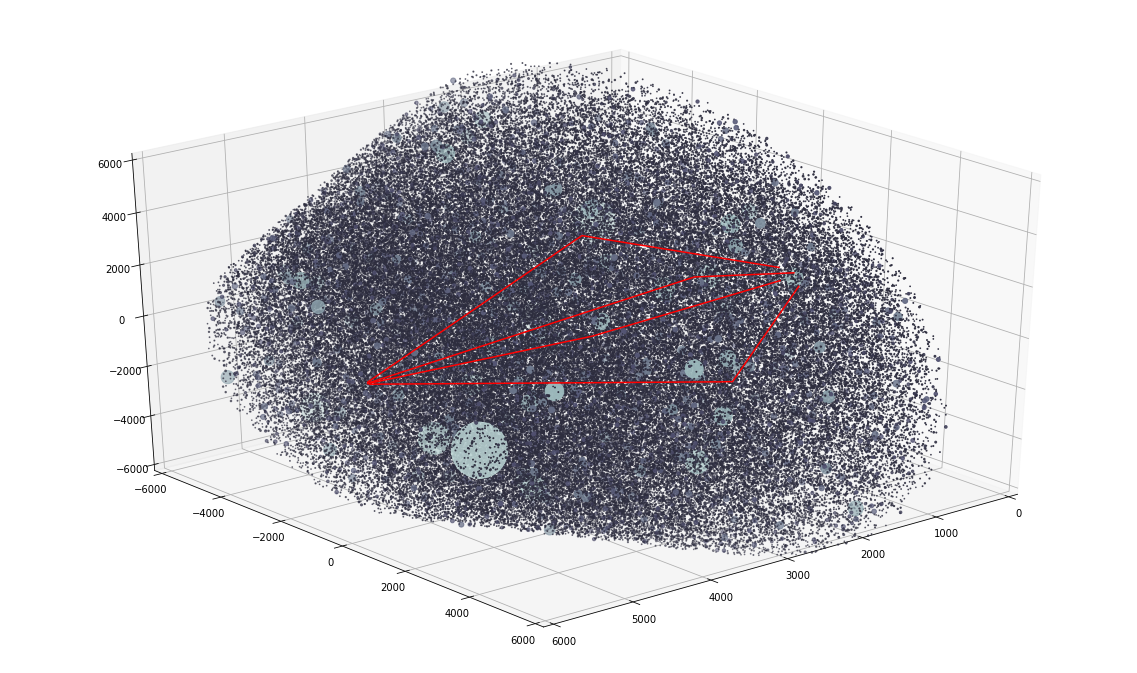

In [16]:
x_angle = []
y_angle = []
z_comoving = []
redshifts = []
masses = []

distance_calc = realization_init.lens_cosmo.cosmo.D_C_transverse
for zi in realization_filtered.unique_redshifts:
    
    d = distance_calc(zi)
    halos_at_redshift, _ = realization_init.halos_at_z(zi)
    for halo in halos_at_redshift:
       
        x_angle.append(halo.x * d)
        y_angle.append(halo.y * d)
        redshifts.append(halo.z)
        masses.append(halo.mass)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

colors = []
cmap = cm.bone
for mi in masses:
    rescaled_mass = max(0.2, (np.log10(mi) - 6) / 4)
    rescaled_mass = min(rescaled_mass, 0.8)
    colors.append(cmap(rescaled_mass))

fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(111, projection='3d')

masses = np.array(masses)
distances_from_halo_redshifts = np.array([distance_calc(zi) for zi in redshifts])
ax.scatter(distances_from_halo_redshifts, x_angle, y_angle, s = 50 * (masses/10**8.)**1., color=colors)

unique_z = np.unique(redshifts)
distances_from_halo_redshifts = np.array([distance_calc(zi) for zi in unique_z])

for i in range(0, len(interpolated_ray_paths_x)):
    
    ray_angle_x = interpolated_ray_paths_x[i](distances_from_halo_redshifts) * distances_from_halo_redshifts
    ray_angle_y = interpolated_ray_paths_y[i](distances_from_halo_redshifts) * distances_from_halo_redshifts
    
    ax.plot(distances_from_halo_redshifts, ray_angle_x, ray_angle_y, color='r')
    
ax.set_xlim(0,6000)
ax.set_ylim(-6000,6000)
ax.set_zlim(-6000,6000)
ax.view_init(30., 50)

## ... and the one where we have removed halos less massive than 10^6 everywhere except 0.15 arcsec apertures around each image. 

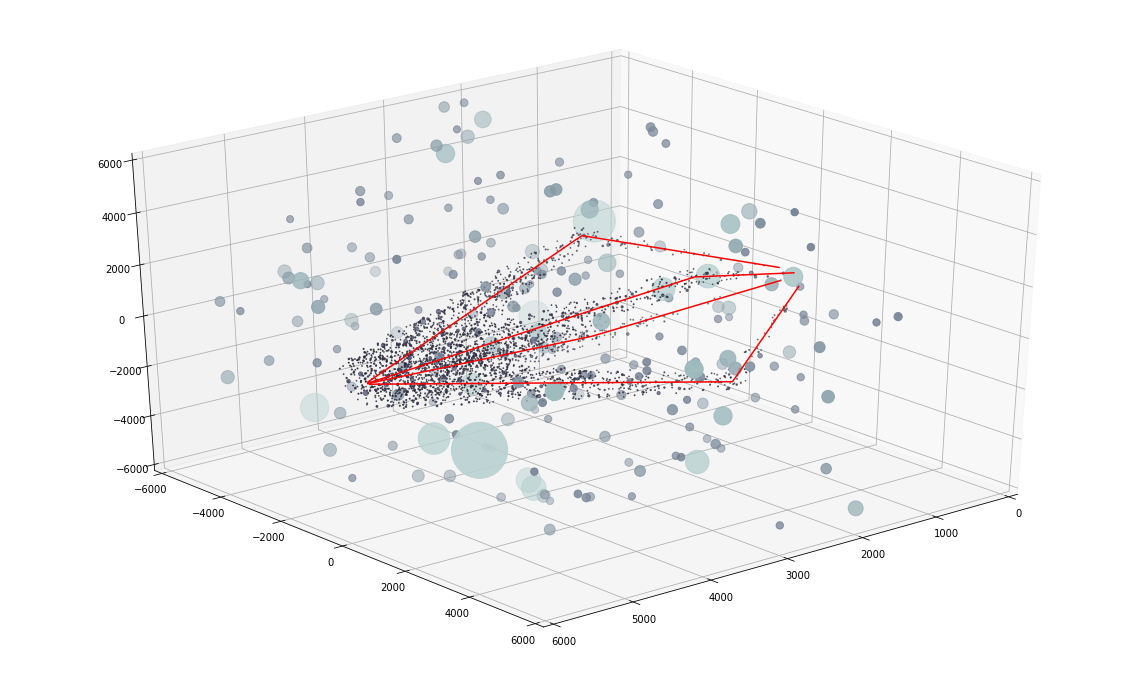

In [15]:
x_angle = []
y_angle = []
z_comoving = []
redshifts = []
masses = []

distance_calc = realization_init.lens_cosmo.cosmo.D_C_transverse
for zi in realization_filtered.unique_redshifts:
    
    d = distance_calc(zi)
    halos_at_redshift, _ = realization_filtered.halos_at_z(zi)
    for halo in halos_at_redshift:
       
        x_angle.append(halo.x * d)
        y_angle.append(halo.y * d)
        redshifts.append(halo.z)
        masses.append(halo.mass)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

colors = []
cmap = cm.bone
for mi in masses:
    rescaled_mass = max(0.2, (np.log10(mi) - 6) / 4)
    rescaled_mass = min(rescaled_mass, 0.8)
    colors.append(cmap(rescaled_mass))

fig = plt.figure()
fig.set_size_inches(20, 12)
ax = fig.add_subplot(111, projection='3d')

masses = np.array(masses)
distances_from_halo_redshifts = np.array([distance_calc(zi) for zi in redshifts])
ax.scatter(distances_from_halo_redshifts, x_angle, y_angle, s = 50 * (masses/10**8.)**1., color=colors)

unique_z = np.unique(redshifts)
distances_from_halo_redshifts = np.array([distance_calc(zi) for zi in unique_z])

for i in range(0, len(interpolated_ray_paths_x)):
    
    ray_angle_x = interpolated_ray_paths_x[i](distances_from_halo_redshifts) * distances_from_halo_redshifts
    ray_angle_y = interpolated_ray_paths_y[i](distances_from_halo_redshifts) * distances_from_halo_redshifts
    
    ax.plot(distances_from_halo_redshifts, ray_angle_x, ray_angle_y, color='r')

ax.set_xlim(0,6000)
ax.set_ylim(-6000,6000)
ax.set_zlim(-6000,6000)
ax.view_init(30., 50)